# Import Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from deep_occupancy_detection import models
import utils

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Data

In [3]:
train_source_X = pd.read_csv("./deep_occupancy_detection/data/2_X_train.csv").values
target_X = pd.read_csv("./deep_occupancy_detection/data/1_X_train.csv").values
train_source_y_task = pd.read_csv("./deep_occupancy_detection/data/2_Y_train.csv").values.reshape(-1)
target_y_task = pd.read_csv("./deep_occupancy_detection/data/1_Y_train.csv").values.reshape(-1)

scaler = preprocessing.StandardScaler()
train_source_X = scaler.fit_transform(train_source_X)
target_X = scaler.fit_transform(target_X)

In [4]:
train_source_y_task_for_bilstm, _ = utils.apply_sliding_window(train_source_y_task.reshape(-1, 1), train_source_y_task, filter_len=3)
train_source_y_task_for_bilstm = train_source_y_task_for_bilstm.reshape(train_source_y_task_for_bilstm.shape[0], train_source_y_task_for_bilstm.shape[1])

train_source_X, train_source_y_task = utils.apply_sliding_window(train_source_X, train_source_y_task, filter_len=3)
target_X, target_y_task = utils.apply_sliding_window(target_X, target_y_task, filter_len=3)
_, test_target_X, _, test_target_y_task = train_test_split(target_X, target_y_task, test_size=0.5, shuffle=False)

In [5]:
train_source_X = torch.tensor(train_source_X, dtype=torch.float32)
train_source_y_task = torch.tensor(train_source_y_task, dtype=torch.float32)
test_target_X = torch.tensor(test_target_X, dtype=torch.float32)
test_target_y_task = torch.tensor(test_target_y_task, dtype=torch.float32)
train_source_y_task_for_bilstm = torch.tensor(train_source_y_task_for_bilstm, dtype=torch.float32)

train_source_X = train_source_X.to(device)
train_source_y_task = train_source_y_task.to(device)
test_target_X = test_target_X.to(device)
test_target_y_task = test_target_y_task.to(device)
train_source_y_task_for_bilstm = train_source_y_task_for_bilstm.to(device)

source_ds = TensorDataset(train_source_X, train_source_y_task)
source_loader = DataLoader(source_ds, batch_size=34, shuffle=False)

source_ds_for_bilstm = TensorDataset(train_source_X, train_source_y_task_for_bilstm)
source_loader_for_bilstm = DataLoader(source_ds_for_bilstm, batch_size=34, shuffle=False)

# Benchmark1. ecodataset_rnn_overlapwindow.ipynb - Domain Classifier, Target Data

In [6]:
hidden_size = 128
num_classes = 1
learning_rate = 0.01

feature_extractor = utils.ManyToOneRNN(input_size=train_source_X.shape[2], hidden_size=hidden_size, num_layers=1).to(device)
task_classifier = utils.Decoder(input_size=hidden_size, output_size=num_classes).to(device)

criterion = nn.BCELoss()
feature_optimizer = optim.Adam(feature_extractor.parameters(), lr=learning_rate)
task_optimizer = optim.Adam(task_classifier.parameters(), lr=learning_rate)

Text(0, 0.5, 'Binary Cross Entropy')

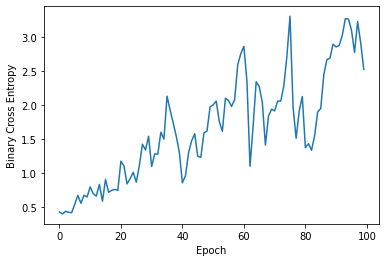

In [99]:
num_epochs = 100
losses = []
# TODO: Refactor, use utils.fit_without_adaptation()
for _ in range(num_epochs):
    feature_extractor.train()
    task_classifier.train()

    for source_X_batch, source_y_task_batch in source_loader:
        # 1. Forward
        pred_y_task = task_classifier(feature_extractor(source_X_batch))
        pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
        loss = criterion(pred_y_task, source_y_task_batch)
        
        # 2. Backward
        task_optimizer.zero_grad()
        feature_optimizer.zero_grad()
        loss.backward()
        

        # 3. Update Params
        feature_optimizer.step()
        task_optimizer.step()
    
    # 4. Evaluation
    feature_extractor.eval()
    task_classifier.eval()
    with torch.no_grad():
        pred_y_task = task_classifier(feature_extractor(test_target_X))
        pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
        loss = criterion(pred_y_task, test_target_y_task)
        losses.append(loss.item())

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy")

In [100]:
pred_y_task = pred_y_task > 0.5
acc = sum(pred_y_task == test_target_y_task) / pred_y_task.shape[0]
print(f"Many To One RNN Accuracy: {acc}")

Many To One RNN Accuracy: 0.7923417091369629


# Benchmark2. BiLSTM-Attention

In [7]:
bilstm_attention = models.AttentionRNN(input_size=train_source_X.shape[2], hidden_size=hidden_size, num_layers=1, num_classes=num_classes).to(device)
bilstm_attention_optimizer = optim.Adam(bilstm_attention.parameters(), lr=learning_rate)

Text(0, 0.5, 'Binary Cross Entropy')

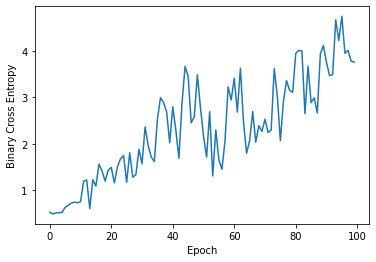

In [9]:
num_epochs = 100
losses = []
for _ in range(num_epochs):
    for batch_x, batch_y_task in source_loader_for_bilstm:
        # 1. Forward
        pred_y_task = bilstm_attention(batch_x, device)
        pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
        loss = criterion(pred_y_task, batch_y_task.reshape(-1))
        
        # 2. Backward
        bilstm_attention_optimizer.zero_grad()
        loss.backward()

        # 3. Update Params
        bilstm_attention_optimizer.step()

    # 4. Evaluation
    with torch.no_grad():
        pred_y_task = bilstm_attention(test_target_X, device)
        pred_y_task = torch.sigmoid(pred_y_task)
        pred_y_task = pred_y_task.reshape(pred_y_task.shape[0], pred_y_task.shape[1])
        pred_y_task = pred_y_task[:, -1]
        
        loss = criterion(pred_y_task, test_target_y_task)
        losses.append(loss.item())
    
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy")

In [11]:
pred_y_task = pred_y_task > 0.5
acc = sum(pred_y_task == test_target_y_task) / test_target_y_task.shape[0]
print(f"BiLSTM-Attention Accuracy: {acc}")

BiLSTM-Attention Accuracy: 0.8100147247314453


# Benchmark3. Random Forest

In [9]:
train_source_X, train_source_y_task = train_source_X.cpu().numpy(), train_source_y_task.cpu().numpy()
test_target_X, test_target_y_task = test_target_X.cpu().numpy(), test_target_y_task.cpu().numpy()
train_source_X = np.mean(train_source_X, axis=1)
test_target_X = np.mean(test_target_X, axis=1)

rf = RandomForestClassifier()
rf.fit(train_source_X, train_source_y_task)

pred_y_task = rf.predict(test_target_X)

In [10]:
acc = sum(pred_y_task == test_target_y_task) / pred_y_task.shape[0]
print(f"Random Forest Accuracy: {acc}")

Random Forest Accuracy: 0.8674521354933726


# Benchmark4. SVM

In [14]:
linear_svm = SVC(kernel="linear")
linear_svm.fit(train_source_X, train_source_y_task)
pred_y_task = linear_svm.predict(test_target_X)
acc = sum(pred_y_task == test_target_y_task) / pred_y_task.shape[0]
print(f"Linear SVM Accuracy: {acc}")

Linear SVM Accuracy: 0.8276877761413843


In [15]:
linear_svm = SVC(kernel="rbf")
linear_svm.fit(train_source_X, train_source_y_task)
pred_y_task = linear_svm.predict(test_target_X)
acc = sum(pred_y_task == test_target_y_task) / pred_y_task.shape[0]
print(f"RBF SVM Accuracy: {acc}")

RBF SVM Accuracy: 0.8379970544918999
